In [1]:
# Installing dependencies
!pip install dipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.0 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 4.0.2
    Uninstalling nibabel-4.0.2:
      Successfully uninstalled nibabel-4.0.2


In [2]:
# Importing libraries
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# Define function for loading nifti images
def load_nifti_files(file_paths):
    data = []
    for file_path in file_paths:
        img = nib.load(file_path)
        data.append(img.get_fdata())
    return np.array(data)

In [4]:
# Downloading required dataset files
import gdown
hdr_ids = ["1V-uHcMuSAe39jETKtb-3oVkDJ7QCIF-y", "15mJ8CxMhyhfbzTVPpF9EMG0rdQClUJ8b", "1rNqIks6jCj-APTAf85eyAzOOQewpsKtH", "1YQ-vQO2tTTcw1bmCkt4COpeWrblsHikb"]
i = 1
for id in hdr_ids:
  url = f'https://drive.google.com/uc?id={id}'
  output = f"/content/{i}.hdr"
  gdown.download(url, output, quiet=False)
  i += 1

img_ids = ["1BBUdxoVWf7bXcoist47Eotlaf6PGrP25", "1ZErMdV5s4EtPxjKYMkZNMWQ7FxUk-6DN", "1gJ3CBEi1uqUy8oBVe7i2m9XP7252vGuV", "1SvwMt0vaK2pzlzR9i80QjkPzut6zFsTE"]
j = 1
for id in img_ids:
  url = f'https://drive.google.com/uc?id={id}'
  output = f"/content/{j}.img"
  gdown.download(url, output, quiet=False)
  j += 1

Downloading...
From: https://drive.google.com/uc?id=1V-uHcMuSAe39jETKtb-3oVkDJ7QCIF-y
To: /content/1.hdr
100%|██████████| 348/348 [00:00<00:00, 1.14MB/s]
Downloading...
From: https://drive.google.com/uc?id=15mJ8CxMhyhfbzTVPpF9EMG0rdQClUJ8b
To: /content/2.hdr
100%|██████████| 348/348 [00:00<00:00, 1.03MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rNqIks6jCj-APTAf85eyAzOOQewpsKtH
To: /content/3.hdr
100%|██████████| 348/348 [00:00<00:00, 1.09MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YQ-vQO2tTTcw1bmCkt4COpeWrblsHikb
To: /content/4.hdr
100%|██████████| 348/348 [00:00<00:00, 1.06MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BBUdxoVWf7bXcoist47Eotlaf6PGrP25
To: /content/1.img
100%|██████████| 33.6M/33.6M [00:01<00:00, 30.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZErMdV5s4EtPxjKYMkZNMWQ7FxUk-6DN
To: /content/2.img
100%|██████████| 33.6M/33.6M [00:00<00:00, 43.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gJ3CBEi1uqUy8oB

In [5]:
# Load the MRI scans and labels
labels = [0, 1, 0, 0]
mri_file_paths = ["/content/1.hdr", "/content/2.hdr", "/content/3.hdr", "/content/4.hdr"]
mri_scans = load_nifti_files(mri_file_paths)
labels = np.array(labels)

print("Shape of MRI scans:", mri_scans.shape)

Shape of MRI scans: (4, 256, 256, 128, 1)


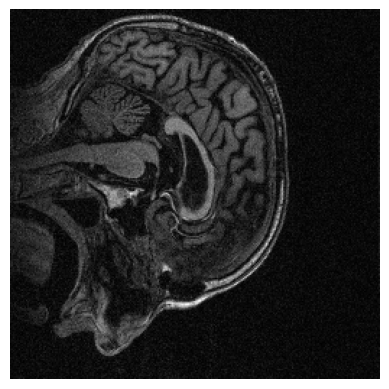

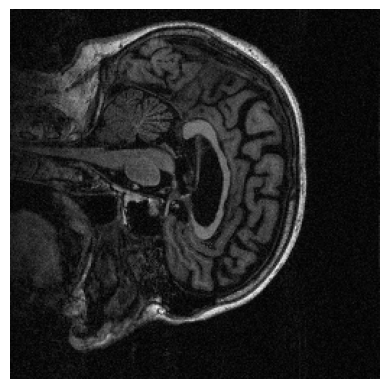

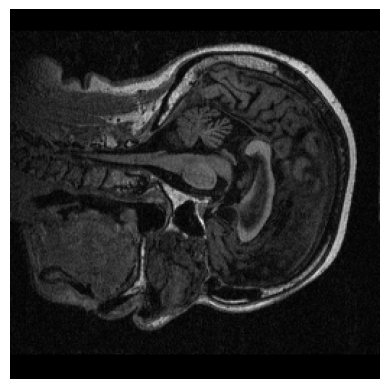

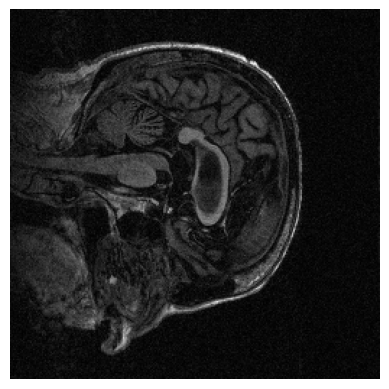

In [6]:
# Display central cross-section of each scan
import matplotlib.pyplot as plt
for scan in mri_scans:
  plt.imshow(scan[:,:,64,0], cmap="gray")
  plt.axis("off")
  plt.show()

In [7]:
# Preprocessing the data to reduce training load
def resize_image(image, new_shape):
    old_shape = np.array(image.shape)
    ratio = new_shape / old_shape
    return zoom(image, ratio, mode='nearest')

resized_scans = np.array([resize_image(scan, (128, 128, 64, 1)) for scan in mri_scans])
print("Shape of preprocessed MRI scans:", resized_scans.shape)

Shape of preprocessed MRI scans: (4, 128, 128, 64, 1)


In [8]:
# Apply histogram equalization on resized scans
from dipy.core.histeq import histeq

equalized_scans = []
for scan in resized_scans:
  data = scan[:,:,:,0]
  equalized = histeq(data)
  equalized_scans.append(equalized)

equalized_scans = np.array(equalized_scans)
print("Shape of equalized MRI scans:", equalized_scans.shape)

Shape of equalized MRI scans: (4, 128, 128, 64)


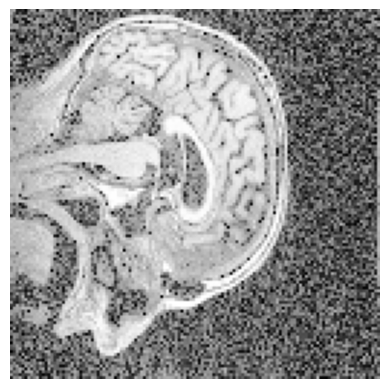

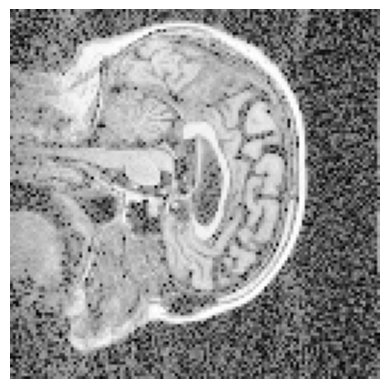

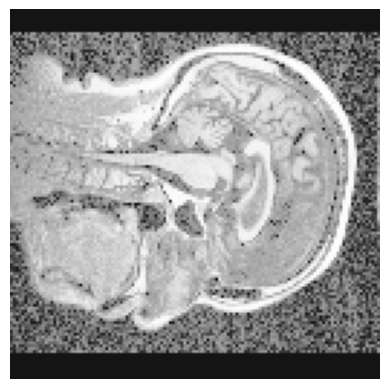

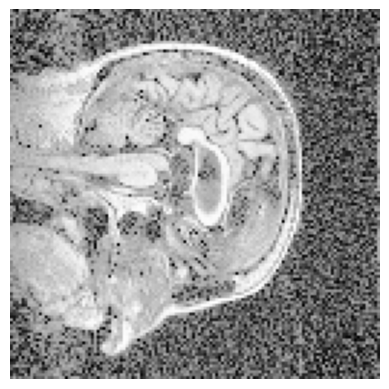

In [9]:
# Display central cross-section after histogram equalization
for scan in equalized_scans:
  plt.imshow(scan[:,:,32], cmap="gray")
  plt.axis("off")
  plt.show()

In [10]:
# Perform skull stripping on resized scans
from dipy.segment.mask import median_otsu

stripped_scans = []
for scan in equalized_scans:
  data = scan[:,:,:]
  stripped, mask = median_otsu(data, median_radius=4, numpass=2, vol_idx=range(data.shape[-1]))
  stripped_scans.append(stripped)

stripped_scans = np.array(stripped_scans)

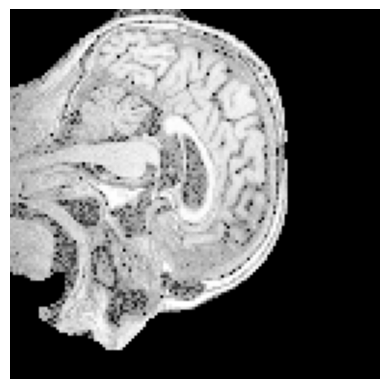

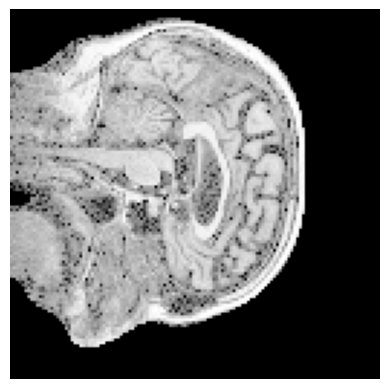

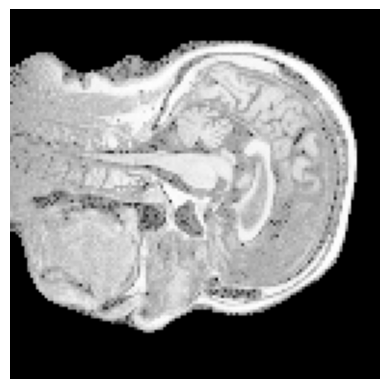

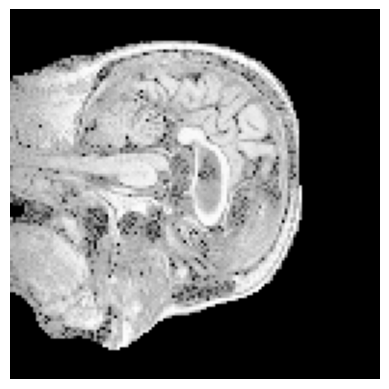

In [11]:
# Display central cross-section after skull stripping
for scan in stripped_scans:
  plt.imshow(scan[:,:,32], cmap="gray")
  plt.axis("off")
  plt.show()

In [18]:
# Perform noise reduction on stripped scans
from scipy.ndimage import gaussian_filter

def apply_noise_reduction(mri_data, sigma=1.0):
    denoised_mri_data = np.empty_like(mri_data)

    for i in range(mri_data.shape[0]):
        denoised_volume = gaussian_filter(mri_data[i, ...], sigma=sigma)
        denoised_mri_data[i, ...] = denoised_volume

    return denoised_mri_data

sigma = 0.5
denoised_mri_scans = apply_noise_reduction(stripped_scans, sigma)

print("Shape of denoised MRI scans:", denoised_mri_scans.shape)


Shape of denoised MRI scans: (4, 128, 128, 64)


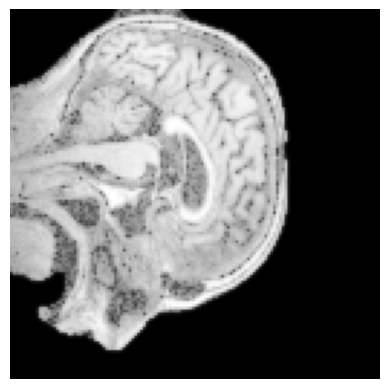

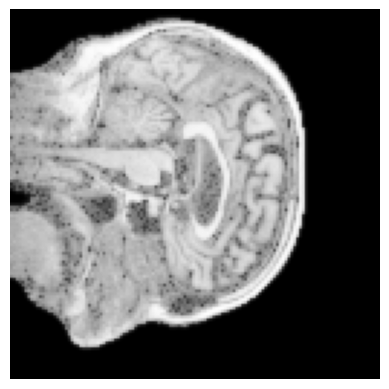

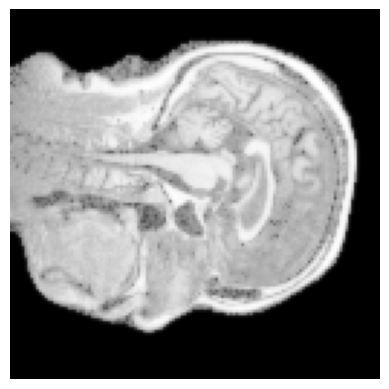

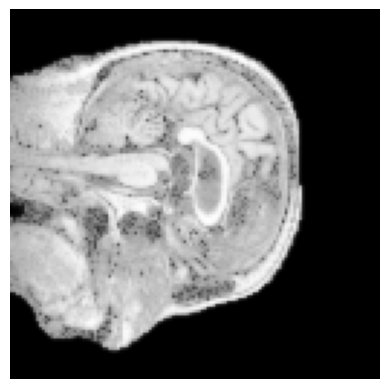

In [19]:
# Display central cross-section after noise reduction
for scan in denoised_mri_scans:
  plt.imshow(scan[:,:,32], cmap="gray")
  plt.axis("off")
  plt.show()